# PyTorch를 이용한 AutoEncoder 구현하기
## MLP (Multi-Layer Perceptron) 구조 vs CNN (Convolutional Neural Network) 구조

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from tqdm import tqdm

# 하이퍼파라미터 설정하기

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

## torchvision.datasets을 이용하여 MNIST 데이터셋 로드하기

In [3]:
mnist_train = dset.MNIST(
    root="./data", 
    train=True, 
    transform=transforms.ToTensor(), 
    target_transform=None, 
    download=True
)
mnist_test = dset.MNIST(
    root="./data", 
    train=False, 
    transform=transforms.ToTensor(), 
    target_transform=None, 
    download=True
)

## torch.utils.data.DataLoader를 이용하여 PyTorch 데이터로더 생성하기

In [4]:
train_loader = torch.utils.data.DataLoader(
    dataset=mnist_train,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=2,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=mnist_test,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2,
    drop_last=True
)

## CNN 기반의 오토인코더 구조 생성하기

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        # input: batch x 3 x 28 x 28
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        # batch x 16 x 28 x 28
                        nn.Conv2d(
                            in_channels=1,
                            out_channels=16,
                            kernel_size=3,
                            padding=1
                        ),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),

                        # batch x 32 x 28 x 28
                        nn.Conv2d(
                            in_channels=16,
                            out_channels=32,
                            kernel_size=3,
                            padding=1
                        ),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),

                        # batch x 64 x 14 x 14
                        nn.Conv2d(
                            in_channels=32,
                            out_channels=64,
                            kernel_size=3,
                            padding=1
                        ),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)            
        )
        self.layer2 = nn.Sequential(
                        # batch x 128 x 7 x 7
                        nn.Conv2d(
                            in_channels=64,
                            out_channels=128,
                            kernel_size=3,
                            padding=1
                        ),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),

                        # batch x 256 x 7 x 7
                        nn.Conv2d(
                            in_channels=128,
                            out_channels=256,
                            kernel_size=3,
                            padding=1
                        ),      
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        # input: batch x 256 x 7 x 7
        self.layer1 = nn.Sequential(
                        # batch x 128 x 14 x 14
                        nn.ConvTranspose2d(
                            in_channels=256,
                            out_channels=128,
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=1
                        ),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),

                        # batch x 64 x 14 x 14
                        nn.ConvTranspose2d(
                            in_channels=128,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1
                        ),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        # batch x 16 x 14 x 14
                        nn.ConvTranspose2d(
                            in_channels=64,
                            out_channels=16,
                            kernel_size=3,
                            stride=1,
                            padding=1
                        ),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),

                        # batch x 1 x 28 x 28
                        nn.ConvTranspose2d(
                            in_channels=16,
                            out_channels=1,
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=1
                        ),         
                        nn.ReLU(),
                        nn.BatchNorm2d(1),

                        # batch x 1 x 28 x 28 (for smoothing)
                        nn.Conv2d(
                            in_channels=1,
                            out_channels=1,
                            kernel_size=3,
                            padding=1
                        ),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

## 원하는 Device (ex: GPU)에 모델 올리고 학습을 위한 준비하기

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 인코더 디코더의 파라미터를 동시에 학습시키기 위해 이를 묶는 방법입니다.
parameters = list(encoder.parameters())+ list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

cuda:0


## 학습하기 (tqdm을 이용하여 학습 진행상황 모니터링 하기)

In [8]:
for i in range(num_epoch):
    for image,label in tqdm(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()

100%|██████████| 234/234 [00:29<00:00,  8.04it/s]


## 학습결과 모니터링하기 (학습 데이터셋을 이용)


torch.Size([256, 28, 28])


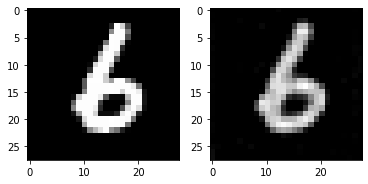

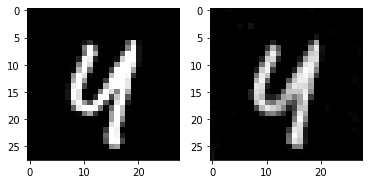

In [9]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 학습결과 모니터링하기 (테스트 데이터셋을 이용)

In [10]:
with torch.no_grad():
    for j,[image,label] in enumerate(test_loader):
       
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)        

torch.Size([256, 28, 28])


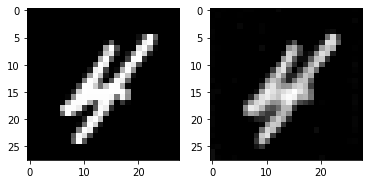

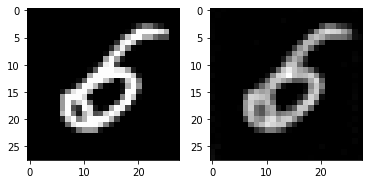

In [11]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()